Ez az első házifeladat azon Mérnökinformatikus BSC hallgatók részére akik a 2023/24/1 félévben Képfeldolgozást hallgatnak.

In [ ]:
# 2023.09.28
# Fülöp Zalán

### Bevezetés
Amikor a kisboltban készpénzzel való fizetés után sietősen távoznék a kasszától néha eszembe jut, hogy segítsek az eladónak megszámolni az aprót. Ennyi matekozás után ez már szakmai ártalom. Mérnöki képességemmel felvértezve azon nyomban automatizált, általános megoldást találok a problémára. Feltételezem, ha az eladó egyszerre csak egy féle érmét lát melynek ismeri az értékét, annak többszörösét (ahány db van) könnyen kiszámolja.<br>
### Feladat
Olyan rendszert fejlesztek mely bemenetként **érméket ábrázoló képet** fogad *és* a megjeleníteni kívánt **érmék értékét**. A rendszer kimenete egy **maszkolt kép** melyen kizárólag a kiválaszott fémpénzek látszanak.
### Adat
Három képet készítettem melyek szélessége és magassága rendre 1000 és 750 képpont. *coin_0_1000x750.jpg* világos (szövet)-, *coin_1_1000x750.jpg* sötét (műbőr) háttér előtt fotózott érmék szerepelnek. Az előbbi kettővel ellentétben *coin_2_1000x750.jpg* kép esetében a háttér változatos színű és mintázatú (padló).<br>
Feladatom megoldását a **coin_1_1000x750.jpg** feldolgozásával kezdem, ez a minimum a házi feladat teljesítését illetően. A másik két képpel való munka, tapasztalatom növelését, szakértelmem elmélyítését és megoldásom általánosítását hivatott szolgálni. 
### Tipp
- Foglalkozz a feladattal egy ültő helyedben annyit amennyi jól esik. Tudásod és önértékelésed élvezi többször felvenni feladatod fonalát.<br>
- A megoldáshoz vezető úton beugrott ötleteket teszteld le kicsiben egy külön cellában.<br>
- **Jegyzetelj!** Kommentelj a celláidba a kódsorok közé. Mit csinál ez a függvény? Miért ezt a módszert használom? Miért választottam ezt az értéket? Kérdezz magadtól! Könnyedén dokumentálod a munkádat ha nyomon követed a megoldási folyamatot. Én is könnyebben megértem a gondolkodásmódod/munkafolyamatod ha olvasom :)

In [1]:
# Importing the necessary libraries
import numpy as np

from matplotlib import pyplot as plt

from PIL import Image

from scipy import ndimage
from scipy import ndimage as ndi

import skimage
from skimage.feature import canny

(750, 1000)


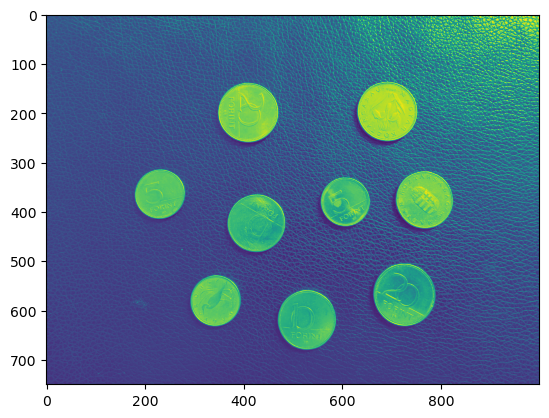

In [17]:
# The images I will be working with
image_names = ['coin_0_1000x750.jpg', 'coin_1_1000x750.jpg', 'coin_2_1000x750.jpg']
# Reading the chosen file
coin_img = Image.open(image_names[1]).convert('L')
# Convert to an array from a grayscale Image object
coin_arr = np.array(coin_img, dtype=np.int32)
# Shape and the image itself
print(coin_arr.shape)
plt.imshow(coin_arr)

0 255
0 255
19.0 252.0
0.0 255.0


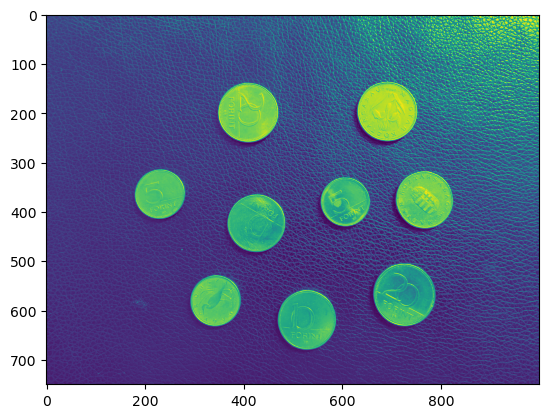

In [3]:
# Preprocessing

# Rescaling intensity with linear transformation into the range of 0 - 255
from skimage import exposure
print(coin_arr.min(), coin_arr.max())
rescaled_image = np.array((coin_arr - np.min(coin_arr)) / (np.max(coin_arr) - coin_arr.min()) * 255, dtype=np.int32) 
print(rescaled_image.min(), rescaled_image.max())


# Clipping underused values at the end of the exposure scale for better contrast
# Minor information loss
v_min, v_max = np.percentile(rescaled_image, (0.2, 99.8))
print(v_min, v_max)
coin_arr = exposure.rescale_intensity(rescaled_image, in_range=(v_min, v_max), out_range=(0, 255))
print(coin_arr.min(), coin_arr.max())
plt.imshow(coin_arr)

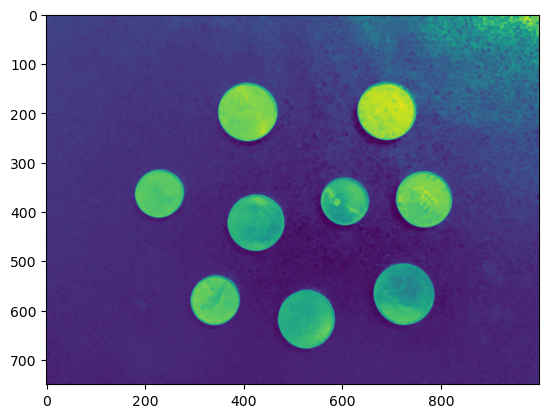

In [5]:
# I will be using morphological operations to clean up the image

from skimage.morphology import disk

# Performing morphological erosion, dilation then closing
s_elem = disk(3)
coin_arr_err = ndimage.grey_erosion(coin_arr, size=(3, 3))
sample_open = ndimage.grey_dilation(coin_arr_err, size=(2, 2))

sample_closed = ndimage.grey_closing(sample_open, size=(5, 5))

plt.imshow(sample_open)

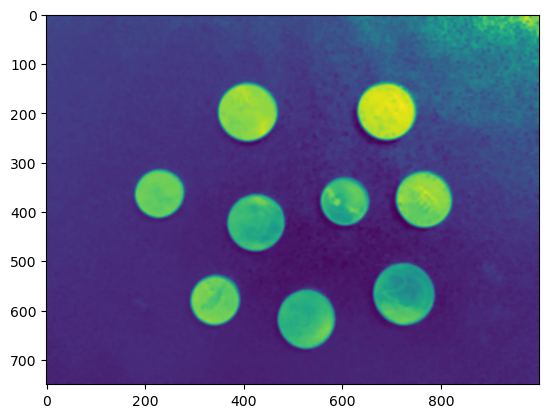

In [29]:
# Gaussian filter for smoothing out the image
coin_arr_filtered = ndimage.gaussian_filter(sample_open, 1)
coin_arr_filtered = ndimage.gaussian_filter(coin_arr_filtered, 1)
coin_arr_filtered = ndimage.gaussian_filter(coin_arr_filtered, 1)
plt.imshow(coin_arr_filtered)

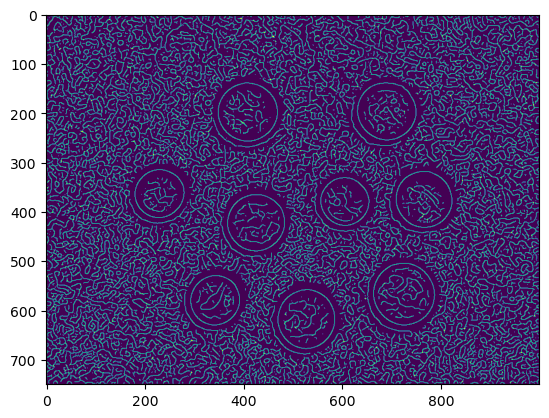

In [30]:
# Finding the edges
edges = canny(coin_arr_filtered, sigma=3)
plt.imshow(edges)

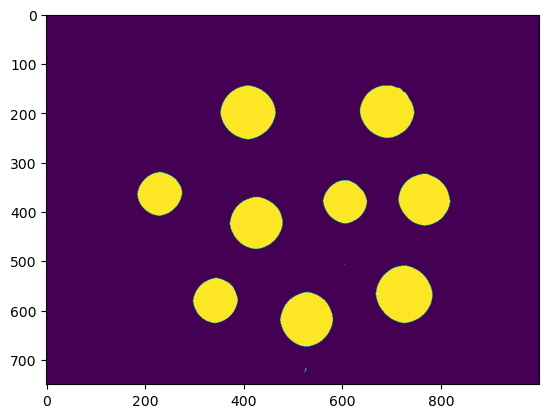

In [31]:
# We fill in the holes enclosed by the edges and then erode the small noises
fill_coins = ndimage.binary_fill_holes(edges)
fill_coins = ndimage.grey_erosion(fill_coins, size=(10,10))
plt.imshow(fill_coins)

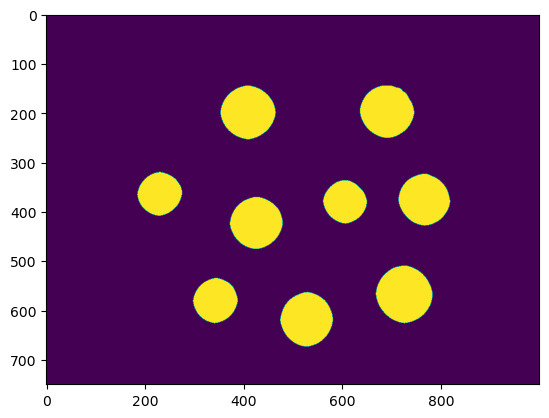

In [32]:
# Labeling and cleaning
label_objects, nb_labels = ndi.label(fill_coins)

sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 10
mask_sizes[0] = 0
coins_cleaned = mask_sizes[label_objects]
plt.imshow(coins_cleaned)

In [33]:
mask_sizes

array([False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False, False, False])

9


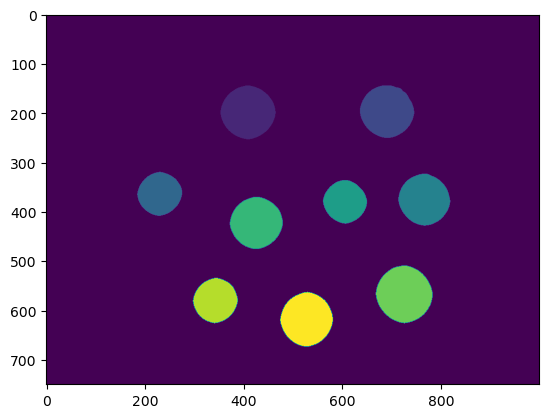

In [34]:
# Labelling the image
labeled_coins, num_of_features = ndi.label(coins_cleaned)
print(num_of_features)
plt.imshow(labeled_coins)

In [35]:
# Use regionprops to extract properties of labeled regions (the found coins)
coin_properties = skimage.measure.regionprops(labeled_coins)
#
print("Number of found features: ", len(coin_properties))

Number of found features:  9


In [36]:
# The areas and the enclosing box coordinates of the found images
for region in coin_properties:
    print(region.area, region.bbox)

9150.0 (145, 354, 254, 466)
8931.0 (145, 637, 251, 747)
5989.0 (320, 185, 409, 276)
8265.0 (324, 715, 429, 820)
5806.0 (337, 562, 425, 651)
8521.0 (371, 373, 476, 480)
10094.0 (510, 669, 627, 784)
6187.0 (535, 298, 627, 389)
8876.0 (563, 475, 674, 582)


In [41]:
# Classifying the values into different classes based on a threshold
# The value of the threshold is quite arbitrary and perhaps wrong
threshold = 900
all_classes = {}

for region in coin_properties:
    found = False
    for avg in all_classes:
        if abs(region.area - avg) <= threshold:
            all_classes[avg].append(region)
            new_avg = np.average([x.area for x in all_classes[avg]])
            all_classes[new_avg] = all_classes.pop(avg)
            found = True
            break

    if not found:
        all_classes[region.area] = [region]

print(all_classes)
print(len(all_classes))

{10094.0: [<skimage.measure._regionprops.RegionProperties object at 0x00000253DAF5B350>], 5994.0: [<skimage.measure._regionprops.RegionProperties object at 0x00000253DDC24490>, <skimage.measure._regionprops.RegionProperties object at 0x00000253DAF58C10>, <skimage.measure._regionprops.RegionProperties object at 0x00000253DAF5ADD0>], 8748.6: [<skimage.measure._regionprops.RegionProperties object at 0x00000253DDC26AD0>, <skimage.measure._regionprops.RegionProperties object at 0x00000253D8DD45D0>, <skimage.measure._regionprops.RegionProperties object at 0x00000253DDC27590>, <skimage.measure._regionprops.RegionProperties object at 0x00000253DAF59190>, <skimage.measure._regionprops.RegionProperties object at 0x00000253DAD6EE50>]}
3


In [42]:
# Sorting the values into their corresponding value list
# The first code is 'nicer' but depends on the above algorithm

# sorted_keys = sorted(all_classes.keys())
# 
# fives = all_classes[sorted_keys[0]]
# tens = all_classes[sorted_keys[1]]
# twenties = all_classes[sorted_keys[2]]

# The classification of coins by size is not really robust, it can suffer greatly from distortion of angles for example
# but building neural networks from scratch, or character recognition would be considerably more difficult 

sorted_coin_properties = sorted(coin_properties, key=lambda x: x.area)
fives = sorted_coin_properties[:3]
tens = sorted_coin_properties[3:6]
twenties = sorted_coin_properties[6:9]

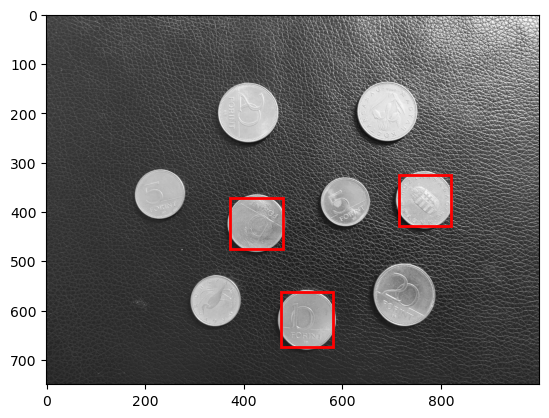

In [43]:
# We show the found regions' outline on the original image

plt.imshow(coin_img, 'gray')

for coin in tens:
    minr, minc, maxr, maxc = coin.bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)
    

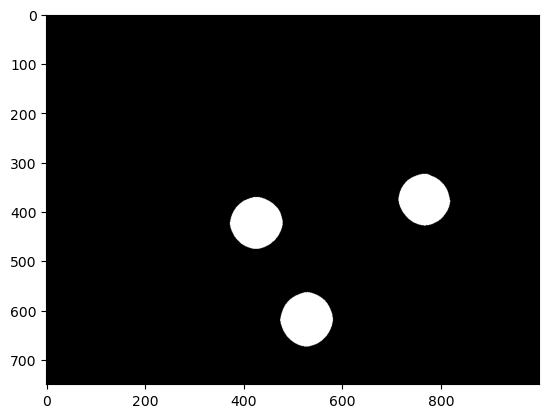

In [44]:
# I defined the mask into a function for ease,
# it calculates the selected coins' mask onto the original image

def get_mask(selected_coins):
    mask = np.zeros_like(coin_img, dtype=np.int8)
    for region in selected_coins:
        # This would get it in a box form
        # minr, minc, maxr, maxc = region.bbox
        # mask[minr:maxr, minc:maxc] = 1
        
        # This get the coordinates that are stored within the region objects
        r, c = skimage.draw.polygon(region.coords[:, 0], region.coords[:, 1])
        mask[r, c] = 1
        
    return mask
    
plt.imshow(get_mask(tens), 'gray')

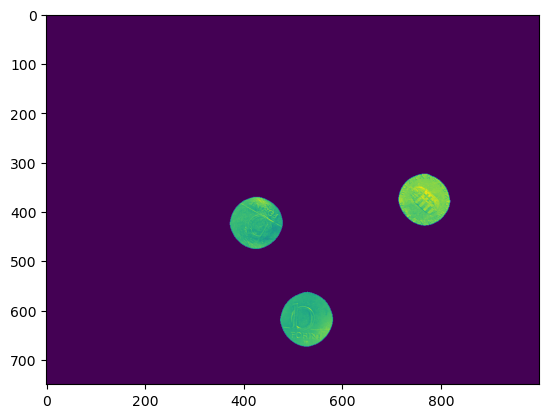

In [45]:
# And now the solution: 
# putting the mask on the original image 
# to get only the parts of the image the we are interested in

plt.imshow(coin_img * get_mask(tens))